In [67]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!pwd

/Users/VictoriaShevchenko/Documents/PhD/COBRE


In [ ]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

In [89]:
# train sample

scz_subjects = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)[:60]
control_subjects = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)[:60]
subjects = np.concatenate((scz_subjects, control_subjects))

group = np.zeros(len(scz_subjects) + len(control_subjects))
group[:len(scz_subjects)] = 1
group = group.astype(bool)
data = np.stack((subjects, group))

In [90]:
# test sample 

scz_subjects_test = np.loadtxt('COBRE_SCZ_subjects.txt', dtype = str)[60:]
control_subjects_test = np.loadtxt('COBRE_controls_subjects.txt', dtype = str)[60:]
subjects_test = np.concatenate((scz_subjects_test, control_subjects_test))

group_test = np.zeros(len(scz_subjects_test) + len(control_subjects_test))
group_test[:len(scz_subjects_test)] = 1
group_test = group_test.astype(bool)

In [91]:
subject_df = pd.DataFrame(data.T, columns = ['Subject', 'Group'])
subject_df_test = pd.DataFrame(np.stack((subjects_test, group_test)).T, columns = ['Subject', 'Group'])

In [92]:
# train grads
scz_grads = []
for subject in scz_subjects:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads.append(grads)
scz_grads = np.stack(scz_grads)

control_grads = []
for subject in control_subjects:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads.append(grads)
control_grads = np.stack(control_grads)


In [93]:
# test grads
scz_grads_test = []
for subject in scz_subjects_test:
    grads = np.load(f'{scz_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    scz_grads_test.append(grads)
scz_grads_test = np.stack(scz_grads_test)

control_grads_test = []
for subject in control_subjects_test:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_test.append(grads)
control_grads_test = np.stack(control_grads_test)

In [94]:
train_grads = np.row_stack((scz_grads, control_grads))
test_grads = np.row_stack((scz_grads_test, control_grads_test))

In [96]:
train_grads.shape

(120, 1000, 10)

# Fit model

In [155]:
X_train_grads = train_grads[:, :, :6].reshape(train_grads.shape[0], -1)
y_train = subject_df['Group'].values

X_test_grads = test_grads[:, :, :6].reshape(test_grads.shape[0], -1)
y_test = subject_df_test['Group'].values


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)


In [156]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_grads, y_train)

LogisticRegression(max_iter=10000)

In [160]:
y_prob = clf.predict_proba(X_test_grads)
y_pred = clf.predict(X_test_grads)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

In [161]:
print(f'Accuracy: {acc}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'F1: {f1}')
print(f'ROC AUC: {roc_auc}')


Accuracy: 0.6590909090909091
Precision: 0.4583333333333333
Recall: 0.8461538461538461
F1: 0.5945945945945945
ROC AUC: 0.7791563275434243


In [170]:
perf_df = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])


In [172]:
deviance_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 65.06365196514136,
 42.16060721688238,
 46.00722086153053,
 46.01949528028038,
 41.93950440626132,
 39.102333728990274,
 39.97502827797142,
 36.24748483064248,
 34.725258053718704,
 34.6214255341343,
 65.06365196514136,
 42.16060721688238,
 46.00722086153053,
 46.01949528028038,
 41.93950440626132,
 39.102333728990274,
 39.97502827797142,
 36.24748483064248,
 34.725258053718704,
 34.6214255341343,
 65.06365196514136,
 42.16060721688238,
 46.00722086153053,
 46.01949528028038,
 41.93950440626132,
 39.102333728990274,
 39.97502827797142,
 36.24748483064248,
 34.725258053718704,
 34.6214255341343]

# Predict

In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

perf_df = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])
acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

for n_grads in range(1, 11):
    X_train_grads = train_grads[:, :, :n_grads].reshape(train_grads.shape[0], -1)
    X_test_grads = test_grads[:, :, :n_grads].reshape(test_grads.shape[0], -1)
    y_train_encoded = le.fit_transform(y_train)

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_grads, y_train)

    y_prob = clf.predict_proba(X_test_grads)
    y_pred = clf.predict(X_test_grads)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df['N_grads'] = np.arange(1, 11)
perf_df['Accuracy'] = acc_list
perf_df['Precision'] = prec_list
perf_df['Recall'] = rec_list
perf_df['F1'] = f1_list
perf_df['ROC_AUC'] = roc_auc_list
perf_df['Deviance'] = deviance_list



LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

LogisticRegression(max_iter=10000)

In [174]:
perf_df

,N_grads,Accuracy,Precision,Recall,F1,ROC_AUC,Deviance
0,1,0.568182,0.392857,0.846154,0.536585,0.746898,65.063652
1,2,0.613636,0.423077,0.846154,0.564103,0.761787,42.160607
2,3,0.636364,0.434783,0.769231,0.555556,0.719603,46.007221
3,4,0.613636,0.416667,0.769231,0.540541,0.741935,46.019495
4,5,0.613636,0.416667,0.769231,0.540541,0.756824,41.939504
5,6,0.659091,0.458333,0.846154,0.594595,0.779156,39.102334
6,7,0.636364,0.440000,0.846154,0.578947,0.769231,39.975028
7,8,0.613636,0.423077,0.846154,0.564103,0.779156,36.247485
8,9,0.590909,0.400000,0.769231,0.526316,0.771712,34.725258
9,10,0.613636,0.423077,0.846154,0.564103,0.776675,34.621426


<Axes: xlabel='N_grads'>

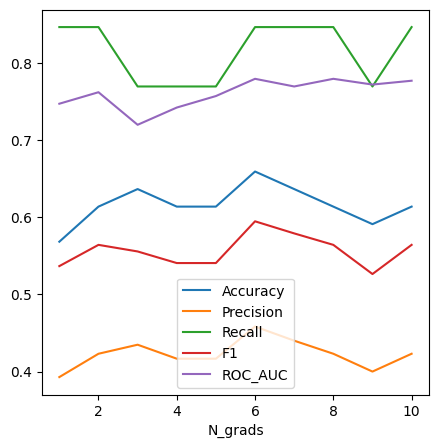

In [176]:
perf_df.plot(x = 'N_grads', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (5, 5))